
# HDF5 streamable version


In [1]:
import os,sys,time
import h5py
import numpy as np
import xarray as xr

# import openvisus
if os.path.isdir(r"C:\projects\OpenVisus\build\RelWithDebInfo"):
	sys.path.append(r"C:\projects\OpenVisus\build\RelWithDebInfo")

import OpenVisus as ov
os.environ["VISUS_DISABLE_WRITE_LOCK"]="1"

from create_streamable import Streamable
from xarray_backend import OpenVisusBackendEntrypoint

# NEEDED
#   OpenVisus need credentials that will extract from s3 config file
#   you need to have a `~/.aws/config` file with the profile
assert(os.path.isfile(os.path.expanduser("~/.aws/config")))

# *** CHANGE AS NEEDED ****
#   NOTE:  always better to have a directory which contains all h5 and OpenVisus file, for this reason I am using `dirname` for templates below

# original file
h5_filename         = './reconstructed_data.nxs'
expression          ='/shanks-3731-a/data/reconstructed_data'
group,fieldname     = expression.rsplit("/",maxsplit=1) # xarray needs to read one level-up (i.e. at group level)

# create streamable local version, where each 3d field will be an OpenVisus dataset
local_url           = f"./streamable/hdf5/reconstructed_data/visus.nxs"

# upload to S3
profile             = "sealstorage"
endpoint_url        = f"https://maritime.sealstorage.io/api/v0/s3"

# this is where to get the file from the network 
# -   NOTE: OpenVisus server does not support serving files such as HDF5 directly, we need a solution on apache
remote_url          = f"https://maritime.sealstorage.io/api/v0/s3/utah/streamable/hdf5/reconstructed_data/visus.nxs?profile=" + profile

# {name} is the internal HDF5 expression to reach the data
idx_urls={

	# alias to a dic item that will be used for the `public`
	"default":         "remote",

	# this is needed to generate interal local dtaset
	"local":            os.path.splitext(local_url)[0]+"/{name}/visus.idx",

	# network s3 storage
	"remote":           os.path.splitext(remote_url)[0]+"/{name}/visus.idx?cached=arco&profile=" + profile, 

	# **TODO** this is missing the {name} in case of multiple fielcs inside the H5
	"remote-atlantis": "https://atlantis.sci.utah.edu/mod_visus?action=readdataset&dataset=reconstructed_data&cached=arco?cached=arco" 
}

from pprint import pprint
pprint(idx_urls)

{'default': 'remote',
 'local': './streamable/hdf5/reconstructed_data/visus/{name}/visus.idx',
 'remote': 'https://maritime.sealstorage.io/api/v0/s3/utah/streamable/hdf5/reconstructed_data/visus/{name}/visus.idx?cached=arco&profile=sealstorage',
 'remote-atlantis': 'https://atlantis.sci.utah.edu/mod_visus?action=readdataset&dataset=reconstructed_data&cached=arco?cached=arco'}


# Read from original HDF5

In [ ]:
ds = xr.open_dataset(h5_filename, group=group)
field=ds[fieldname]
data=field[...].values
print("Got data","type",type(data),"shape",data.shape,"dtype",data.dtype,"min",np.min(data),"max",np.max(data))

You can use H5glance too
- Execute `!{sys.executable} -m pip install --quiet h5glance` if needed

In [ ]:
from h5glance import H5Glance
H5Glance(h5_filename)

# Create streamable version

In [2]:
arco  = "2mb"
compression = "zip"
Streamable.Create(h5_filename, local_url, arco=arco, compression=compression, idx_urls=idx_urls)

DANGEROUS but needed: removing any old data file from ./streamable/hdf5/reconstructed_data/visus/shanks-3731-a/data/reconstructed_data/visus
Read data in 6.944638729095459 seconds shape=(676, 856, 949) dtype=float32 vmin=-0.08980203419923782 vmax=0.030067643150687218
Created IDX idx_url=[./streamable/hdf5/reconstructed_data/visus/shanks-3731-a/data/reconstructed_data/visus.idx] idx_axis=[x y z] idx_physic_box=[-0.77774 0.6253 -0.70078 0.56462 1.01602 2.01502]
Wrote IDX data in 5.221867561340332 seconds
Compressing dataset compression=zip...
Compressed dataset to zip in 18.582656145095825 seconds
Found already converted dataset, using the link /shanks-3731-a/reconstructed_data/data/reconstructed_data->/shanks-3731-a/data/reconstructed_data
new-size/old-size=83,912/1,847,736,861


In [3]:
Streamable.Print(local_url)

 /
   @HDF5_Version=1.14.1
   @default=shanks-3731-a
   @file_name=/nfs/chess/user/rv43/user_examples/tomo/shanks-3731-a/ti-2-exsitu/reconstructed_data.nxs
   @file_time=2023-11-14T10:02:06.830431
   @h5py_version=3.9.0
   @nexusformat_version=1.0.2
   /shanks-3731-a
     @NX_class=NXentry
     @default=data
     /shanks-3731-a/bright_field_config shape='()' dtype='object'
     /shanks-3731-a/dark_field_config shape='()' dtype='object'
     /shanks-3731-a/data
       @NX_class=NXdata
       @axes=['z' 'y' 'x']
       @idx_url=https://maritime.sealstorage.io/api/v0/s3/utah/streamable/hdf5/reconstructed_data/visus/shanks-3731-a/data/reconstructed_data/visus.idx?cached=arco&profile=sealstorage
       @idx_urls={'default': 'remote', 'local': './streamable/hdf5/reconstructed_data/visus/shanks-3731-a/data/reconstructed_data/visus.idx', 'remote': 'https://maritime.sealstorage.io/api/v0/s3/utah/streamable/hdf5/reconstructed_data/visus/shanks-3731-a/data/reconstructed_data/visus.idx?cached=arco

# Read  local 

ov.LoadDataset(./streamable/hdf5/reconstructed_data/visus/shanks-3731-a/data/reconstructed_data/visus.idx)
None
Adding field  reconstructed_data shape  [1, 676, 856, 949, 31] dtype  float32 labels  ['time', 'phony_dim_0', 'phony_dim_1', 'phony_dim_2', 'resolution'] Max Resolution  30
None
Got data type <class 'numpy.ndarray'> shape (338, 428, 475) dtype float32 min -0.050708987 max 0.030067643


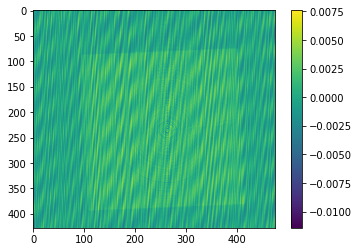

In [4]:
ds = xr.open_dataset(local_url, group=group, engine=OpenVisusBackendEntrypoint, prefer="local")
field=ds[fieldname]
timestep,res=0,27
data=field[timestep,...,res].values
print("Got data","type",type(data),"shape",data.shape,"dtype",data.dtype,"min",np.min(data),"max",np.max(data))

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
im = ax.imshow(data[100,...]) 
plt.colorbar(im)

# Upload all folder (H5 files and IDX data) to S3

It is important to have an unique folder to simplify the upload
- **TODO** OpenVisus server would need a modification to the `visus.config` file , so it's not easy to make the upload automatic

In [5]:
!{sys.executable} -m pip install --quiet awscli-plugin-endpoint
!aws s3 sync --no-progress --endpoint-url {endpoint_url} --profile {profile} --size-only {os.path.dirname(local_url)}/ s3:/{os.path.dirname(remote_url)[len(endpoint_url):]}/

upload: streamable\hdf5\reconstructed_data\visus.nxs to s3://utah/streamable/hdf5/reconstructed_data/visus.nxs
upload: streamable\hdf5\reconstructed_data\visus\shanks-3731-a\data\reconstructed_data\visus.idx to s3://utah/streamable/hdf5/reconstructed_data/visus/shanks-3731-a/data/reconstructed_data/visus.idx


#  Read from S3

- the streamable file already contains `cached=arco` so it should automatically cache data
- check your `~/visus/` directory for cache

ov.LoadDataset(https://maritime.sealstorage.io/api/v0/s3/utah/streamable/hdf5/reconstructed_data/visus/shanks-3731-a/data/reconstructed_data/visus.idx?cached=arco&profile=sealstorage)
None
Adding field  reconstructed_data shape  [1, 676, 856, 949, 31] dtype  float32 labels  ['time', 'phony_dim_0', 'phony_dim_1', 'phony_dim_2', 'resolution'] Max Resolution  30
None
Got data type <class 'numpy.ndarray'> shape (338, 428, 475) dtype float32 min -0.050708987 max 0.030067643


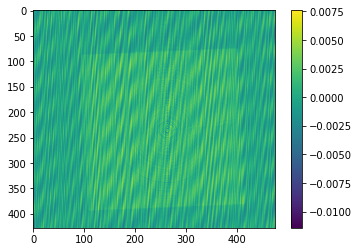

In [6]:
# directly opening the stream using f3fs is causing some problems with `xr.open_dataset` so I am saving the file locally first
temp_local_url=Streamable.SaveRemoteToLocal(remote_url, profile=profile, endpoint_url=endpoint_url)

ds=xr.open_dataset(temp_local_url, group=group, engine=OpenVisusBackendEntrypoint, prefer="remote")
field=ds[fieldname]
timestep,res=0,27
data=field[timestep,...,res].values
print("Got data","type",type(data),"shape",data.shape,"dtype",data.dtype,"min",np.min(data),"max",np.max(data))

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
im = ax.imshow(data[100,...]) 
plt.colorbar(im)

# Read from atlantis

ov.LoadDataset(https://atlantis.sci.utah.edu/mod_visus?action=readdataset&dataset=reconstructed_data&cached=arco?cached=arco)
None
Adding field  reconstructed_data shape  [1, 676, 856, 949, 31] dtype  float32 labels  ['time', 'phony_dim_0', 'phony_dim_1', 'phony_dim_2', 'resolution'] Max Resolution  30
None
Got data type <class 'numpy.ndarray'> shape (338, 428, 475) dtype float32 min -0.050708987 max 0.030067643


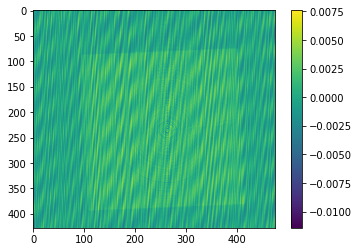

In [7]:
# OpenVisus server does not support serving any file such as streamable HDF5, so I need another place
ds=xr.open_dataset(local_url, group=group, engine=OpenVisusBackendEntrypoint, prefer="remote-atlantis")
field=ds[fieldname]
timestep,res=0,27
data=field[timestep,...,res].values
print("Got data","type",type(data),"shape",data.shape,"dtype",data.dtype,"min",np.min(data),"max",np.max(data))

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
im = ax.imshow(data[100,...]) 
plt.colorbar(im)

# TODO

- support of direct HDF5  (i.e. using `h5py` with `HDF5_PLUGIN_PATH`)
- support of direct NEXUS (i.e. ?)